# Recommendation System - Amazon Eletronics

The dataset was possible thanks to Addressing Marketing Bias in Product Recommendations. Mengting Wan, Jianmo Ni, Rishabh Misra, Julian McAuley. WSDM, 2020. It was download on [this link](https://github.com/MengtingWan/marketBias).
***

## Exploring the data

Let's start taking a look at the data and deciding which features can be used or manipuled in order to build the recommendation system.

In [40]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('data/df_electronics.csv')

In [2]:
# Checking the first rows of the data
data.head()

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0


In [3]:
# Checking data's info such as shape, type of each column and null items
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292954 entries, 0 to 1292953
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   item_id     1292954 non-null  int64  
 1   user_id     1292954 non-null  int64  
 2   rating      1292954 non-null  float64
 3   timestamp   1292954 non-null  object 
 4   model_attr  1292954 non-null  object 
 5   category    1292954 non-null  object 
 6   brand       331120 non-null   object 
 7   year        1292954 non-null  int64  
 8   user_attr   174124 non-null   object 
 9   split       1292954 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 98.6+ MB


Let's check the rating column, which is going to be the the most important feature

In [4]:
data.describe()['rating']

count    1.292954e+06
mean     4.051482e+00
std      1.379732e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Lets split the data in order to use only rating, item and user id columns.

In [5]:
data = data[['item_id', 'user_id', 'rating']]

Now lets confirm the missing values

In [6]:
data.isnull().sum()

item_id    0
user_id    0
rating     0
dtype: int64

Since there is none (as we could see also during the .info() method), lets move to plot the data.

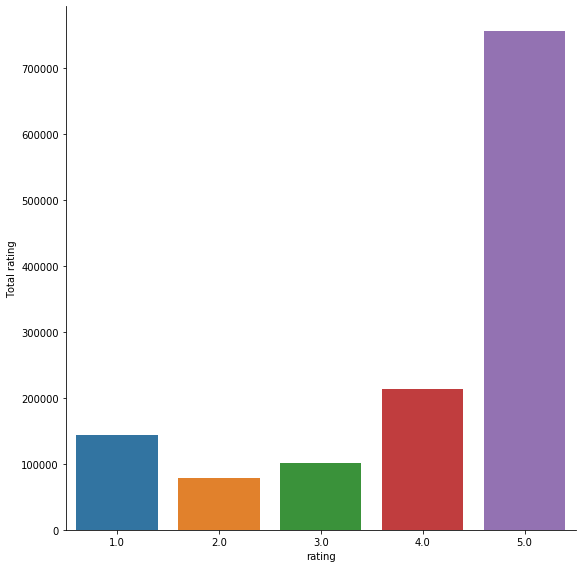

In [7]:
# Plotting the rating count
plot = sns.catplot('rating', data=data, kind='count', height=8)
plot.set_ylabels('Total rating')

It seems that most of the people gives a 5 rate.

Lets check for unique users and products now.

In [8]:
print(f'Total number of ratings: {data.shape[0]}')
print(f'Total number of users: {len(np.unique(data.user_id))}')
print(f'Total number of products: {len(np.unique(data.item_id))}')

Total number of ratings: 1292954
Total number of users: 1157633
Total number of products: 9560


There are almost as much users as lines in the dataset but there are only 9560 products.

Lets then take a look at the mean rating of each product and the number of ratings given and the relationship between then

In [9]:
df_rating = pd.DataFrame({'count_rate': data.groupby('item_id').count()['rating'], 'mean_rate': data.groupby('item_id').mean()['rating']})

28530

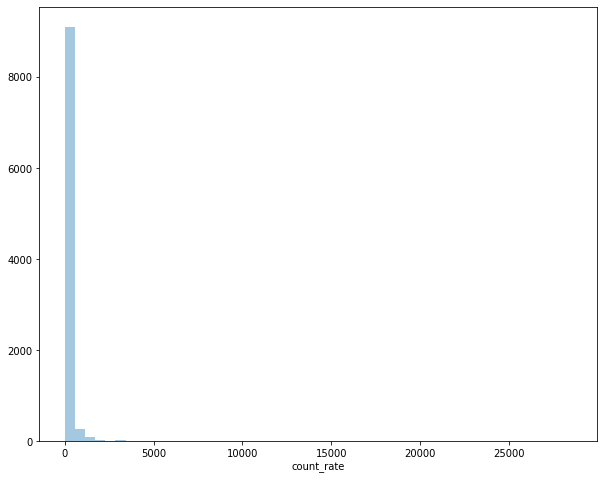

In [10]:
plt.figure(figsize=(10,8))
sns.distplot(df_rating['count_rate'], kde=False)
df_rating['count_rate'].max()

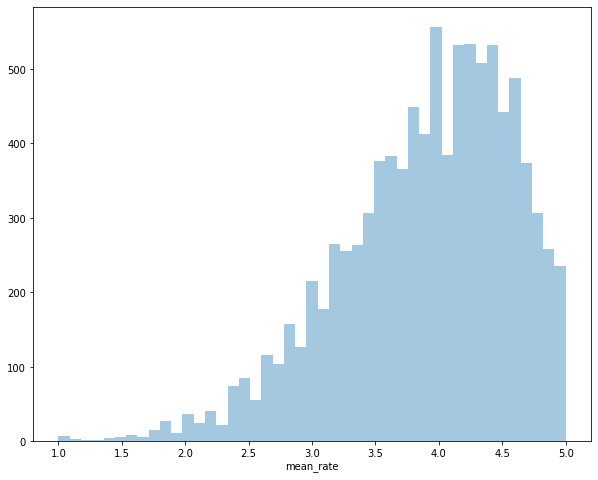

In [11]:
plt.figure(figsize=(10,8))
sns.distplot(df_rating['mean_rate'], kde=False)

Text(0.5, 0.98, 'Count rating x Mean Rating')

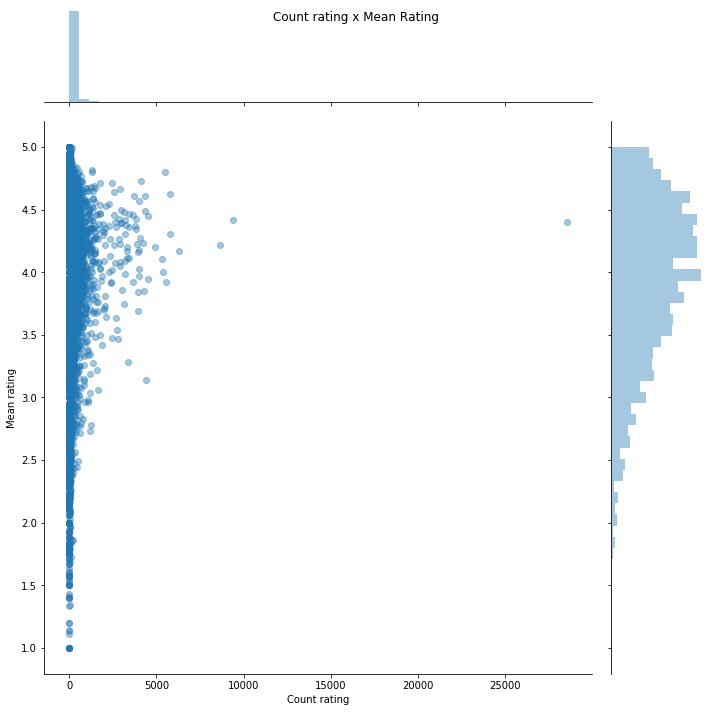

In [12]:
plot = sns.jointplot(x='count_rate', y='mean_rate', data=df_rating, alpha=0.4, height=10)
plot.set_axis_labels('Count rating', 'Mean rating')
plot.fig.suptitle('Count rating x Mean Rating')

It's possible to see from the graphs that the number of ratings are less than 2500 and most of the products have a mean rating between 3.5 and 4.8.

It's also possible to plot by rating quantity to check the most popular product

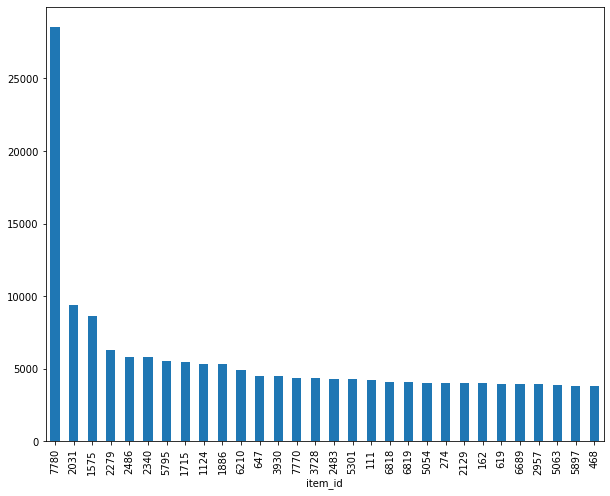

In [13]:
plt.figure(figsize=(10,8))
df_rating.sort_values(by='count_rate', ascending=False)['count_rate'].head(30).plot(kind='bar')

***
## Definning the approach

There are many types of recommendation system. According to [Maruti Techlabs](https://towardsdatascience.com/what-are-product-recommendation-engines-and-the-various-versions-of-them-9dcab4ee26d5) the three most important are:

__Content-Based Recommender__: Based on the description of an item and a profile of the user’s preferred choices. In a content-based recommendation system, keywords are used to describe the items; besides, a user profile is built to state the type of item this user likes.

__Collaborative Recommender__: Usually based on collecting and analyzing information on user’s behaviors, their activities or preferences and predicting what they will like based on the similarity with other users.

__Hybrid Recommender__: Hybrid approaches can be implemented by making content-based and collaborative-based predictions separately and then combining them. 
    
To use the given data, however, the __popularity-based recommender__, which offers generalized recommendations to every user, based on product popularity, will work better because it recommends same products to all users and it does not give personalized recommendations to users. Besides that it will be possible to apply the __collaborative__ and __hybrid__ recomender as well.

### Popularity-based recommender

This recommender is pretty simple because it just needs to sort the products by its rates in a defined metric and shows the top products. The IMDB's weighted rating formula fits well and it follows the equation:
\begin{align}
Weighted Rating (WR) = (\frac{v}{v+m} \cdot R) + (\frac{m}{v+m} \cdot C)
\end{align}

where:
__v__ is the number of rating;
__m__ is the minimum number of rating required;
__R__ is the mean rating and
__C__ is the total mean rating;

In [14]:
print(f'C = {df_rating.mean_rate.mean()}')

C = 3.8964310770267514


Lets define m. Its possible to use a percentile for that. The 60th should work, which means that the counting rating for a product must be higher than 60% products of the list.

In [15]:
df_filtered = df_rating[df_rating['count_rate'] > df_rating['count_rate'].quantile(q=0.60)]
df_filtered.shape

(3785, 2)

There are 3785 products in the filtered list.

Lets now create a method to calculate the WR function

In [16]:
def wr(data):
    v = data['count_rate']
    m = df_rating['count_rate'].quantile(q=0.60)
    R = data['mean_rate']
    C = df_rating['mean_rate'].mean()
    
    return((R*v/(v+m))+(C*m/(v+m)))

In [17]:
aux = df_filtered.apply(wr, axis=1)
aux_df = pd.DataFrame({'score': aux})

df_concat = pd.concat([df_filtered, aux_df], axis=1)
df_concat.head()

,count_rate,mean_rate,score
item_id,,,
0,118,3.542373,3.632008
1,58,3.844828,3.865890
2,3404,4.464160,4.457566
3,155,3.251613,3.383883
14,58,4.500000,4.253645


Finally the 5:

In [18]:
df_highscore = df_concat.sort_values(by='score', ascending=False).head(5)
df_highscore

,count_rate,mean_rate,score
item_id,,,
1647,185,4.994595,4.799366
1715,5482,4.797337,4.790811
2016,1330,4.815789,4.788947
4968,1300,4.800769,4.773774
3840,431,4.832947,4.753412


### Collaborative Recommender

The popularity-based recommender have some limitations. It does not capture personal biases, which means that anyone, besides its profile, will receive the same recommendations. 

The collaborative recommender takes people with similar interests and gives recommendations based on this match. In order to do that lets use one of the most popular algorithms for this kind of engine, the Truncated SVD algorithm. In addition to that the RMSE is going to be used as an error estimator and a kfold cross validation in order to minimize the latest.

The [surprise library](http://surpriselib.com/) is going to support the necessary methods

In [19]:
# Importing necessary libraries
from surprise import SVD, Reader, Dataset, accuracy
from surprise.model_selection import cross_validate, train_test_split

svd = SVD()
reader = Reader(rating_scale=(1,5))
data_svd = Dataset.load_from_df(data, reader)

Lets run 5-fold cross validation over our data

In [20]:
cross_validate(svd, data_svd, measures = ['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3083  1.3051  1.3049  1.3089  1.3097  1.3074  0.0020  
MAE (testset)     1.0374  1.0346  1.0344  1.0383  1.0386  1.0367  0.0018  
Fit time          103.16  104.98  115.82  110.78  116.79  110.31  5.51    
Test time         3.37    3.39    3.48    3.54    3.23    3.40    0.11    


{'test_rmse': array([1.30828111, 1.30510563, 1.30491006, 1.30888931, 1.30970277]),
 'test_mae': array([1.0373707 , 1.0345743 , 1.03443722, 1.03827947, 1.03863737]),
 'fit_time': (103.16463994979858,
  104.98389005661011,
  115.81843614578247,
  110.77941918373108,
  116.78756666183472),
 'test_time': (3.369821786880493,
  3.3921475410461426,
  3.4765379428863525,
  3.5437870025634766,
  3.2266170978546143)}

An approximate 1.3 RMSE is a good indicator. Lets now train the data and make the predictions.

Lets split the data into train and test set and train the model.

In [21]:
train, test = train_test_split(data_svd, test_size=0.3, random_state=10)
svd.fit(train)

Now lets calculate the RMSE for the test set.

In [22]:
test_pred = svd.test(test)
accuracy.rmse(test_pred, verbose=True)

RMSE: 1.3103


1.310320494477544

And use the model to predict a score that a user would give to an item.

In [23]:
svd.predict(uid='13', iid='285', r_ui=None).est

4.052740846810236

### Hybrid Recommender

Ending with the hybrid recommender that will combine the pearson correlation coefficients with the collaborative recommender.

In [31]:
# Manipulating data to use the hybrid engine

# Taking the first 10k items
data_hybrid = data[:9999]

matrix = pd.pivot_table(data=data_hybrid, values='rating', index='user_id', columns='item_id')

user_id
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9681   NaN
9682   NaN
9683   NaN
9684   NaN
9685   NaN
Name: 13, Length: 9686, dtype: float64

Lets create a mehotd to use corrwith() method to compute correlation between the dataframe columns and calculate pearson correlation coefficients.

In [51]:
def hybrid_recommendations(user_id, item_id):
    
    # Find the top 5 most correlated with the item chosen by the user
    best = matrix.corrwith(matrix[item_id]).sort_values(ascending=False).head(5)
    
    # Predict the ratings that the user might give to these top 5 most correlated items
    print(best)
    est_ratings = []
    for item in list(best.index):
        if not math.isnan(item):
            est_ratings.append(svd.predict(user_id, iid=item, r_ui=None).est)
    
    return pd.DataFrame({'item_id':list(best.index)[:len(est_ratings)], 'estimated_rating':est_ratings}).sort_values(by='estimated_rating', ascending=False).reset_index(drop=True)

In [52]:
hybrid_recommendations('13', 285)

item_id
285    1.0
0      NaN
1      NaN
2      NaN
3      NaN
dtype: float64


,item_id,estimated_rating
0,0,4.154751
1,285,4.052741
2,1,4.052741
3,2,4.052741
4,3,3.854267
